In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score

# 데이터셋 불러오기
df = pd.read_csv('/content/drive/MyDrive/deep_learning/Final_Project/data.csv')

In [2]:
# 범주형 열을 인코딩
encoder = LabelEncoder()
df['structure_encoded'] = encoder.fit_transform(df['structure'])
df['category_encoded'] = encoder.fit_transform(df['category'])

# 특징과 타겟 정의
X = df.drop(['name', 'log_breakdown_field', 'structure', 'category'], axis=1)
y = df['log_breakdown_field'].values

*=== test2 start ===*

In [3]:
# 학습 및 테스트 데이터 분리
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# 검증 및 테스트 데이터 분리
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [4]:
# 텐서로 변환
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# TensorDataset과 DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [5]:
# 다층 퍼셉트론 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 128)  # 은닉층 크기 조정
        self.layer3 = nn.Linear(128, 64)  # 은닉층 추가
        self.layer4 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)  # 드롭아웃 추가

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x

# 입력, 은닉, 출력 차원 설정
input_dim = X_train_tensor.shape[1]
hidden_dim = 256
output_dim = 1

# 모델 생성
model = MLP(input_dim, hidden_dim, output_dim)

# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 조기 종료 설정
patience = 10  # 성능 향상이 없을 때 기다릴 에포크 수
best_val_loss = float('inf')
patience_counter = 0

In [ ]:
model

MLP(
  (layer1): Linear(in_features=10, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
epochs = 1000
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for input, target in train_loader:
        y_train_pred = model(input)
        loss = criterion(y_train_pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input, target in val_loader:
            y_val_pred = model(input)
            loss = criterion(y_val_pred, target)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if (epoch + 1) % 25 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")

    # 조기 종료 조건 확인
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 25/1000, Train Loss: 0.433, Val Loss: 0.467
Epoch 50/1000, Train Loss: 0.263, Val Loss: 0.269
Early stopping at epoch 70


In [ ]:
def evaluation(dataloader):
    predictions = torch.tensor([], dtype=torch.float)
    actual = torch.tensor([], dtype=torch.float)
    model.eval()

    with torch.no_grad():
        for inputs, targets in dataloader:
            y_test_pred = model(inputs)
            predictions = torch.cat((predictions, y_test_pred), 0)
            actual = torch.cat((actual, targets), 0)

    predictions = predictions.numpy()
    actual = actual.numpy()
    r2 = r2_score(actual, predictions)
    return r2, predictions, actual

train_r2, _, _ = evaluation(train_loader)
val_r2, _, _ = evaluation(val_loader)
test_r2, test_predictions, test_actual = evaluation(test_loader)

print(f"Train R2: {train_r2:.3f}")
print(f"Validation R2: {val_r2:.3f}")
print(f"Test R2: {test_r2:.3f}")

Train R2: 0.886
Validation R2: 0.732
Test R2: -1.297


In [ ]:
# 정확도 계산 함수
def accuracy(predictions, actual, threshold=0.1):
    correct = np.abs(predictions - actual) < threshold
    accuracy = np.mean(correct)
    return accuracy

# 테스트 데이터 정확도 평가
test_accuracy = accuracy(test_predictions, test_actual)
print(f"test_predictions : {test_predictions}, test_actual : {test_actual}")
print(f"Test Accuracy: {test_accuracy:.3f}")

test_predictions : [[ 6.9441075]
 [ 4.3020463]
 [ 6.8033156]
 [ 3.9034104]
 [ 6.1937985]
 [ 5.931792 ]
 [ 4.887894 ]
 [ 8.454209 ]
 [ 6.1160827]
 [ 5.040693 ]
 [ 4.723576 ]
 [ 2.888613 ]
 [10.810963 ]], test_actual : [[6.9685683]
 [5.0119677]
 [6.1733694]
 [4.342506 ]
 [7.3839273]
 [6.416896 ]
 [4.9670315]
 [8.482519 ]
 [5.6660805]
 [4.5705786]
 [4.5196123]
 [3.744787 ]
 [5.676411 ]]
Test Accuracy: 0.231


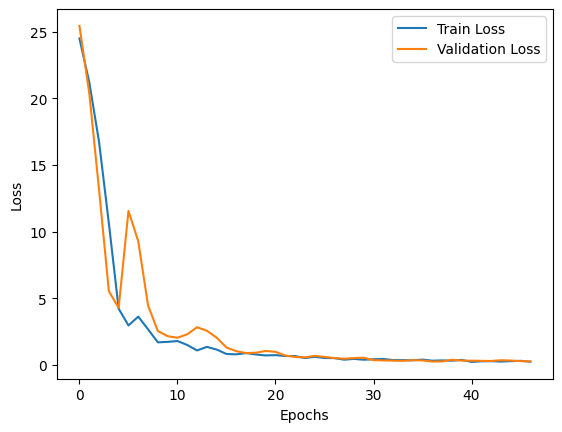

In [ ]:
# 학습 및 검증 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

*=== test2 End ===*

In [ ]:
# 범주형 열을 인코딩
encoder = LabelEncoder()
df['structure_encoded'] = encoder.fit_transform(df['structure'])
df['category_encoded'] = encoder.fit_transform(df['category'])

# 특징과 타겟 정의
X = df.drop(['name', 'log_breakdown_field', 'structure', 'category'], axis=1)
y = df['log_breakdown_field'].values

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 텐서로 변환
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# TensorDataset과 DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 64)
        self.layer3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

input_dim = X_train_tensor.shape[1]
hidden_dim = 128
output_dim = 1

# 모델 생성
model = MLP(input_dim, hidden_dim, output_dim)

In [ ]:
model

MLP(
  (layer1): Linear(in_features=10, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# 손실 함수 및 optimizer 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

*==== test start ====*

In [ ]:
epochs = 200
train_losses = []

for epoch in range(epochs):
  model.train()
  train_loss = 0.0

  for input, target in train_loader:
    y_train_pred = model(input)

    loss = criterion(y_train_pred, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  if (epoch + 1) % 25 == 0:
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.3f}")

Epoch 25/200, Train Loss: 1.134
Epoch 50/200, Train Loss: 0.345
Epoch 75/200, Train Loss: 0.191
Epoch 100/200, Train Loss: 0.141
Epoch 125/200, Train Loss: 0.106
Epoch 150/200, Train Loss: 0.079
Epoch 175/200, Train Loss: 0.075
Epoch 200/200, Train Loss: 0.056


In [ ]:
train_dataset[0]

(tensor([-0.6958,  0.2661,  0.4051,  0.6110,  0.0510, -0.7246, -0.4386,  0.1552,
          0.9996,  0.2526]),
 tensor([5.3351]))

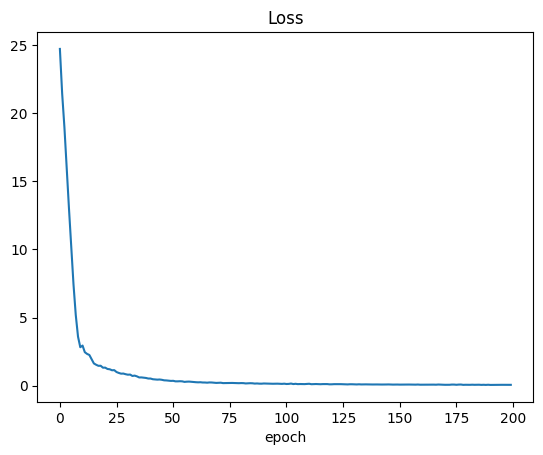

In [ ]:
plt.plot(train_losses)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def evaluation(dataloder):

  predictions = torch.tensor([], dtype=torch.float)
  actual = torch.tensor([], dtype=torch.float)
  model.eval()

  with torch.no_grad():
    for inputs, targets in dataloder:
      y_test_pred = model(inputs)

      predictions = torch.cat((predictions, y_test_pred), 0)
      actual = torch.cat((actual, targets), 0)

  predictions = predictions.numpy()
  actual = actual.numpy()
  r2 = r2_score(actual, predictions)

  return r2

In [ ]:
train_r2 = evaluation(train_loader)
test_r2 = evaluation(test_loader)

In [ ]:
print(f'train_r2:{train_r2}')
print(f'test_r2:{test_r2}')

train_r2:0.9515445791804862
test_r2:-0.19233887961450513


*==== test end =====*

In [ ]:
# 모델 학습
epochs = 1000
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y_train_pred = model(X_batch)
        loss = criterion(y_train_pred, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_test_pred = model(X_batch)
            loss = criterion(y_test_pred, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    if (epoch + 1) % 25 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}")

Epoch 25/1000, Train Loss: 0.083, Test Loss: 1.790
Epoch 50/1000, Train Loss: 0.074, Test Loss: 1.671
Epoch 75/1000, Train Loss: 0.075, Test Loss: 1.549
Epoch 100/1000, Train Loss: 0.066, Test Loss: 1.490
Epoch 125/1000, Train Loss: 0.048, Test Loss: 1.452
Epoch 150/1000, Train Loss: 0.040, Test Loss: 1.404
Epoch 175/1000, Train Loss: 0.032, Test Loss: 1.380
Epoch 200/1000, Train Loss: 0.029, Test Loss: 1.329
Epoch 225/1000, Train Loss: 0.026, Test Loss: 1.274
Epoch 250/1000, Train Loss: 0.021, Test Loss: 1.191
Epoch 275/1000, Train Loss: 0.017, Test Loss: 1.123
Epoch 300/1000, Train Loss: 0.013, Test Loss: 1.089
Epoch 325/1000, Train Loss: 0.014, Test Loss: 1.040
Epoch 350/1000, Train Loss: 0.009, Test Loss: 0.982
Epoch 375/1000, Train Loss: 0.007, Test Loss: 0.953
Epoch 400/1000, Train Loss: 0.005, Test Loss: 0.937
Epoch 425/1000, Train Loss: 0.004, Test Loss: 0.917
Epoch 450/1000, Train Loss: 0.004, Test Loss: 0.914
Epoch 475/1000, Train Loss: 0.003, Test Loss: 0.904
Epoch 500/1000,

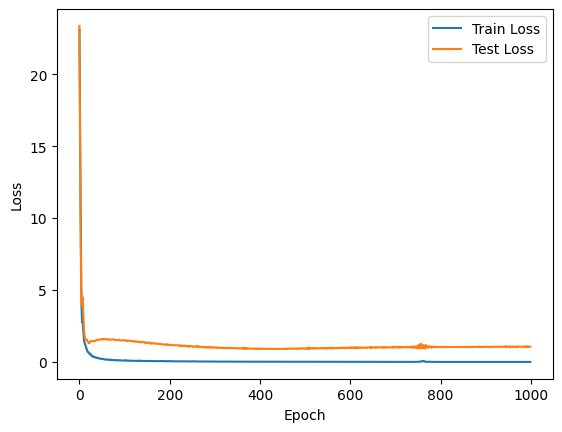

R2 Score: 0.046


In [ ]:
# 학습 손실 및 테스트 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 모델 평가
model.eval()
with torch.no_grad():
   y_test_pred = model(X_test_tensor).numpy()

r2 = r2_score(y_test, y_test_pred)
print(f'R2 Score: {r2:.3f}')